In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import low_rank_models as lrm

/home/yuji/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
df = pd.read_csv('error_matrix_small.csv', index_col=0)
models = np.array(list(df))
dataset_IDs = df.index.values
errorMtx = df.values
n_datasets, n_models = errorMtx.shape

In [3]:
RANK = 9
LAMBDA = 10
MU = 10
LEARNING_RATE = 0.01
N_EPOCHS = 10000

In [4]:
x = tf.placeholder(tf.float32, shape=[None, n_models], name='input')

reg1 = tf.constant(0.0)  # regularizer enforcing at most RANK weights are active
reg2 = tf.constant(0.0)  # regularizer enforcing weights are boolean

with tf.variable_scope('encoder'):
    we = tf.get_variable('w', 
                        initializer=tf.constant(0.5*np.ones([n_models, RANK]), dtype=tf.float32),
                        constraint=lambda x: tf.clip_by_value(x, 0, 1))
    encoded = tf.matmul(x, we)
    reg1 += LAMBDA * tf.nn.l2_loss(tf.reduce_sum(we, axis=0) - tf.constant(np.ones(RANK), dtype=tf.float32))
    reg2 += MU * (1 - tf.nn.l2_loss(we - 0.5))

with tf.variable_scope('decoder_1'):
    wd1 = tf.get_variable('w', initializer=tf.truncated_normal([RANK, n_models]))
    bd1 = tf.get_variable('b', initializer=tf.zeros([n_models]))
    d1 = tf.matmul(encoded, wd1) + bd1
    
'''
with tf.variable_scope('decoder_2'):
    wd2 = tf.get_variable('w', initializer=tf.truncated_normal([n_models, n_models]))
    bd2 = tf.get_variable('b', initializer=tf.zeros([n_models]))
    d2 = tf.matmul(d1, wd2) + bd2
'''
    
loss = tf.nn.l2_loss(x - d1)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(loss + reg1 + reg2)
init = tf.global_variables_initializer()

In [5]:
sess = tf.InteractiveSession()
sess.run(init)

for i in range(N_EPOCHS):
    sess.run(optimizer, feed_dict={x:errorMtx})
    if i%1000 == 999 or i==0:
        l,r1,r2 = sess.run([loss, reg1, reg2], feed_dict={x:errorMtx})
        print("epoch %6d, loss=%6f, regularizer1=%0.4f, regularizer2=%0.4f" % (i+1, l, round(r1, 4), round(r2, 4)))

epoch      1, loss=447312.625000, regularizer1=14758.7324, regularizer2=9.8245
epoch   1000, loss=37.681728, regularizer1=11.1907, regularizer2=-405.8844
epoch   2000, loss=29.264065, regularizer1=13.9621, regularizer2=-408.7283
epoch   3000, loss=24.608765, regularizer1=14.0327, regularizer2=-409.0702
epoch   4000, loss=20.146942, regularizer1=12.3999, regularizer2=-408.6731
epoch   5000, loss=15.522758, regularizer1=9.4348, regularizer2=-408.3458
epoch   6000, loss=13.605826, regularizer1=6.7661, regularizer2=-411.4686
epoch   7000, loss=13.945888, regularizer1=4.7108, regularizer2=-416.8752
epoch   8000, loss=12.823904, regularizer1=1.2494, regularizer2=-422.7158
epoch   9000, loss=9.460233, regularizer1=0.0451, regularizer2=-427.2458
epoch  10000, loss=6.916154, regularizer1=0.1014, regularizer2=-428.1393


In [6]:
w = np.array(sess.run([we]))[0]

In [7]:
np.sum(w, axis=0)

array([ 1.        ,  1.        ,  1.14242291,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ], dtype=float32)

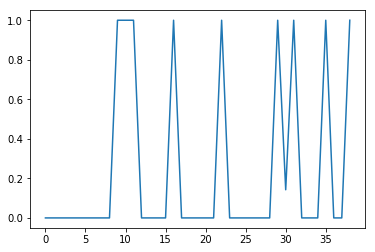

In [8]:
plt.plot(np.arange(39), np.sum(w, axis=1))
plt.show()

In [9]:
np.argsort(-np.sum(w, axis=1))[:RANK]

array([38, 16, 11, 22,  9, 29, 10, 35, 31])